# Group project - Computational Game Theory

# Playing gridwold game

In this game 2 agents should coorperate with each other to reach the goal state without running into each other.
Both players can have their own learning algorithms assigned to make comparing different learners possible.
This is done in an abstract way to make testing alternate situations easy.

## TOC
- Group info
- Important note
- Required imports
- Storing and loading variables
- Code to represent the players and games
   - The WolfGridPlayer class
   - The PhcGridPlayer class
   - The GridGame class
   - The average_games function
- Playing the game (WoLF)
- Playing the game (HCP)
- Plotting averages
- Plotting single run

## Student info
| Name     | Student number                        | Email address                               |
| :---     | :---                          | :---                                |
| Alexis Francois Verdoodt | _ | _ |
| Lennert Bontinck | 568702 | [lennert.bontinck@vub.be](mailto:lennert.bontinck@vub.be) |
| Sofyan Ajridi | _ | _ |
| Wolf De Wulf | 546395 | [wolf.de.wulf@vub.be](mailto:wolf.de.wulf@vub.be) |

## Important note
In some codeblocks, the code might refer to variables from previous sections, in order to get accurate results code must be run top to bottom without skipping. The result of some lengthy processes is saved to a Pickle file to make the results available for reuse later.

## Required imports
All imports required for this notebook.

In [1]:
# General imports
import numpy as np
import random
import statistics as stats
import math
from scipy import stats as sstats

# Allow for deep copying instead of python references (default)
import copy

# Plotting imports
import matplotlib.pylab as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'svg'}

# Library to save vars to files
import pickle

## Storing and loading variables
Improves reproducibility and allows for using previous results of lengthy processes.

In [2]:
def save_var_to_file(filename, network):
    with open('savefiles/' + filename +'.pkl','wb') as f:
        pickle.dump(network, f)

def get_var_from_file(filename):
    with open('savefiles/' + filename +'.pkl','rb') as f:
        return pickle.load(f)
    
    
#-------------------------

#save to file example
#save_var_to_file("folder/name", var_to_save)
    
#open from file example
#get_var_from_file = get_var_from_file("folder/name")

## Code to represent the players and games
Let's start by making a way of representing the games and playing them in an abstract manner.

### The WolfGridPlayer class
A class for defining a RPC player according to the WoLF algorithm.

In [79]:
class WolfGridPlayer:
    """
    A class used to represent a grid player using the WoLF algorithm.
    Keeps track of it's current state and the map available.
    Running into a wall will result in staying in the same location.
    Running into another player will result in staying in the same location.
    Reaching goal wil result in all players returning to their initial state.
    Makes use of a time-varrying alpha and delta thus it's not needed to specify these.

    ...

    Attributes
    ----------
    q_values : list
        List containing the player's current q values estimate for rock (0), paper (1) and scissors (1).
    
    TODO : TODO
        TODO 
        
    Methods
    -------
    choose_action()
        Chooses an action based on the current policy probabilities estimate for  rock (0), paper (1) and scissors (1).
        There's a 0.05 probability of chosing a random action for exploration.
        Returns the chosen action, which is thus represented as an integer.
    
    TODO : TODO
        TODO
    
    Helper Methods
    -------
    player_is_winning()
        Returns a bool specifying if a user is winning or not
    
    TODO : TODO
        TODO
    """
    def __init__(self, initial_q_value, initial_policy_probabilities, gamma, starts_left):
        """
        Parameters
        ----------
        TODO : TODO
            TODO
        """
        self.grid_sizes = [2, 2] # start counting from 0 -> 3x3 grid -> h x w
        
        self.start_state = [2 , 0] if starts_left else [2 , 2] #[2 , 0] = lower left corner, other lower right
        self.current_state = [2 , 0] if starts_left else [2 , 2]
        self.actions = [i for i in range(4)] # N S E W for each state and non changing
        self.state_counts = [[0 for _ in range(3)] for _ in range (3)]

        self.q_values = [[[initial_q_value]*4 for _ in range(3)] for _ in range (3)] # N S E W q-val for each state of 3 x 3 grid
        self.policy_probabilities = [[[initial_policy_probabilities]*4 for _ in range(3)] for _ in range (3)] # N S E W for each state of 3 x 3 grid
        self.average_policy_probabilities = [[[initial_policy_probabilities]*4 for _ in range(3)] for _ in range (3)] # N S E W for each state of 3 x 3 grid
        self.gamma = gamma
        
        
        
        
    
    def choose_action(self):       
        # give room for some exploration (e.g. stuck in an extreme)
        if  random.random() < 0.05:
            in_start = self.current_state == self.start_state
            move = random.choice(self.actions)
            goal_state = self.get_new_state_for_move(move, True, False)
            return [in_start, move, goal_state]
        
        # generate cumulative probabilities
        cum_probs = np.cumsum(self.policy_probabilities_for_current_state())
        
        # chose an action for the cumulative probs
        rnd = random.uniform(0, np.max(cum_probs))
        for move in range(len(cum_probs)):
            if (rnd <= cum_probs[move]):
                in_start = self.current_state == self.start_state
                goal_state = self.get_new_state_for_move(move, True, False)
                return [in_start, move, goal_state]
        
     
    def increment_state_count(self):
        state = self.current_state
        self.state_counts[state[0]][state[1]] += 1
        
    
    def update_q_value_for_action(self, action, received_reward, move_failed):
        crt_alpha = self.timed_alpha()
        state = self.current_state
        new_state = self.get_new_state_for_move(action, False, move_failed)
        self.q_values[state[0]][state[1]][action] = ((1-crt_alpha) * self.q_values[state[0]][state[1]][action]) + (crt_alpha * (received_reward + (self.gamma * np.max(self.q_values[new_state[0]][new_state[1]]))))
                
    
    def update_average_policy_probabilities(self):
        state = self.current_state
        c = self.state_counts[state[0]][state[1]]
    
        for action in self.actions:
            polprob = self.policy_probabilities_for_current_state()[action]
            avgpolprob = self.average_policy_probabilities_for_current_state()[action]
            self.average_policy_probabilities[state[0]][state[1]][action] += (1/c)*(polprob-avgpolprob)
    
  
    def update_policy_probabilities(self):
        #determine delta
        delta = self.timed_winning_delta() if self.player_is_winning() else self.timed_losing_delta()
        
        #determine 1 max q-value
        state = self.current_state
        max_action = np.argmax(self.q_values[state[0]][state[1]])
        
        #first check if there is an action with prob 0, rescale if so
        test_delta_will_work = [max(prob-delta, 0) for prob in self.policy_probabilities[state[0]][state[1]]]
        non_viable = test_delta_will_work.count(0)
        scale = 3 - non_viable
        
        if scale == 0:
            delta = 0
            scale = 1
        
        for action in self.actions:
            if action == max_action:
                self.policy_probabilities[state[0]][state[1]][action] = min(1.0,  self.policy_probabilities[state[0]][state[1]][action] + delta)
            else: #devide losing over 2 from the 3 actions
                self.policy_probabilities[state[0]][state[1]][action] = max(0.0,  self.policy_probabilities[state[0]][state[1]][action] - (delta/scale))

    def go_back_to_start(self):
        self.current_state = self.start_state
        
    def perform_move(self, move, move_failed):
        self.current_state = self.get_new_state_for_move(move, False, move_failed)
        
    def get_policy_probabilities_for_start_state(self):
        state = self.start_state
        return self.policy_probabilities[state[0]][state[1]]
        
        
       
    def player_is_winning(self):
        policy_sum = 0
        avg_policy_sum = 0
        state = self.current_state
        for action in self.actions:
            policy_sum += self.policy_probabilities[state[0]][state[1]][action] * self.q_values[state[0]][state[1]][action]
            avg_policy_sum += self.average_policy_probabilities[state[0]][state[1]][action] * self.q_values[state[0]][state[1]][action]
            
        return policy_sum > avg_policy_sum
    
    
    def timed_alpha(self):
        state = self.current_state
        return 1 / (10 + (self.state_counts[state[0]][state[1]]/500))
    
    
    def timed_winning_delta(self): 
        state = self.current_state
        return 1 / (1000 + (self.state_counts[state[0]][state[1]]/10))
    
    
    def timed_losing_delta(self): 
        state = self.current_state
        return 4 / (1000 + (self.state_counts[state[0]][state[1]]/10))
    
    
    def policy_probabilities_for_current_state(self): 
        state = self.current_state
        return self.policy_probabilities[state[0]][state[1]]
    
    
    def average_policy_probabilities_for_current_state(self): 
        state = self.current_state
        return self.average_policy_probabilities[state[0]][state[1]]
    
    
    def get_new_state_for_move(self, move, with_random, move_failed):  
        crt_state = self.current_state
        #move failed
        if move_failed:
            return crt_state
        
        #calculate move
        if (crt_state == self.start_state and move == 0 ):
            rnd = random.random()
            if rnd < 0.5 and with_random:
                return crt_state #failed
            else:
                return [crt_state[0] - 1, crt_state[1]] #move up
        elif (move == 0): # N
            new_height = max(crt_state[0] - 1, 0)
            return [new_height, crt_state[1]]
        elif (move == 1): # S
            new_height = min(crt_state[0] + 1, self.grid_sizes[0])
            return [new_height, crt_state[1]]
        elif (move == 2): # E
            new_width = min(crt_state[1] + 1, self.grid_sizes[1])
            return [crt_state[0], new_width]
        else: # W
            new_width = max(crt_state[1] - 1, 0)
            return [crt_state[0], new_width]
            

### The PHCRPCPlayer class - TODO
A class for defining a RPC player according to the PHC algorithm.
Some of the WoLF specific functions will just be dummy functions

### The GridGame class
This game does't require the notion of states since the results are indepent of a given state. Thus the transition function can simply return the initial start state for every iteration.

In [17]:
class GridGame:
    """
    A class used to represent a RPC game.
    Has no notion of state since there is only 1 state.

    ...

    Attributes
    ----------
    TODO
    
    Methods
    -------
    TODO
    """
    def __init__(self, players, goal_state):
        """
        Parameters
        ----------
        players : list
            List containing all (2) players for the game.
        """
        self.players = players
        self.goal_state = goal_state
        
        
        
        
        
    def play_game(self, iterations):
        results_player1 = [0]*iterations
        results_player2 = [0]*iterations
        
        for iteration in range(iterations):        
            #debug
            #print(self.players[0].policy_probabilities[self.players[0].start_state[0]][self.players[0].start_state[1]])
            
            
            # determine player moves TODO
            player1_in_start, player1_move, player1_goal_state = self.players[0].choose_action()
            player2_in_start, player2_move, player2_goal_state = self.players[1].choose_action()
            
            # check if players collide (unless goal state)
            collision = (player1_goal_state == player2_goal_state and player1_goal_state != self.goal_state)
            
            # check if goal reached
            goal_reached = (player1_goal_state == self.goal_state or player2_goal_state == self.goal_state)
                    
            # add to state count
            self.players[0].increment_state_count()
            self.players[1].increment_state_count()
            
            # calculate corresponding reward and update q-value
            reward_p1 = 100 if player1_goal_state == self.goal_state else 0
            reward_p2 = 100 if player2_goal_state == self.goal_state else 0
            self.players[0].update_q_value_for_action(player1_move, reward_p1, collision)
            self.players[1].update_q_value_for_action(player2_move, reward_p2, collision)
            
            # update estimate of average policy
            self.players[0].update_average_policy_probabilities()
            self.players[1].update_average_policy_probabilities()
            
            # update policy
            self.players[0].update_policy_probabilities()
            self.players[1].update_policy_probabilities()
            
            # perform the actual move
            if goal_reached:
                self.players[0].go_back_to_start()
                self.players[1].go_back_to_start()
            else:
                self.players[0].perform_move(player1_move, collision)
                self.players[1].perform_move(player2_move, collision)
            
            # save result: prob north and east for player 1, prob north and west for player 2
            # prob: n s e w 
            results_player1[iteration] = copy.deepcopy(self.players[0].get_policy_probabilities_for_start_state())
            results_player2[iteration] = copy.deepcopy(self.players[1].get_policy_probabilities_for_start_state())
                
        return [results_player1, results_player2]

### The average_games function - TODO

In [5]:
def average_games(game, iterations, trials):
    results_player1 = [[0]*iterations for _ in range(trials)] 
    results_player2 = [[0]*iterations for _ in range(trials)] 
    for trial in range(trials):
        copied_game = copy.deepcopy(game)
        results_player1[trial], results_player2[trial] = copied_game.play_game(iterations)
    return results_player1, results_player2
        

## Playing the game (WoLF) - TODO

In [83]:
initial_q_value = 0
initial_policy_probabilities = 1/4
gamma = 0.6
iterations = 100000
averaging_amount = 1

player1 = WolfGridPlayer(initial_q_value, initial_policy_probabilities, gamma, True)
player2 = WolfGridPlayer(initial_q_value, initial_policy_probabilities, gamma, False)
players = [player1, player2]

game = GridGame(players, [0, 1])

results_player1, results_player2 = average_games(game, iterations, averaging_amount)
save_var_to_file("grid/wolf_result_player1", results_player1)
save_var_to_file("grid/wolf_result_player2", results_player2)

In [84]:
results_player1[0][-1]

[0.9995387760073204,
 0.00015374133089306066,
 0.00015374133089306066,
 0.00015374133089306066]

In [85]:
results_player2[0][-1]

[0.9994964776028133,
 0.00016784079906174184,
 0.00016784079906174184,
 0.00016784079906174184]

## Playing the game (PHC | time-varying) - TODO

## Plotting single run - TODO

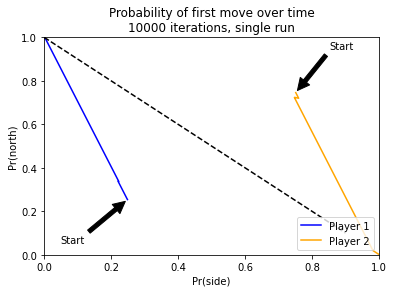

In [65]:
# get the results
results = [["Player 1", get_var_from_file("grid/wolf_result_player1")],
           ["Player 2", get_var_from_file("grid/wolf_result_player2")]]

colors = ["blue",
         "orange"]


# --------------------------------------------------------------------------
color_idx = 0
player = 0
for result in results:
    # get a single run
    result_data = result[1][0]
    
    
    
    result_north = [data[0] for data in result_data]
    result_sideways = [data[2 if player == 0 else 3] for data in result_data]
    
    
    if result[0] == "Player 2": # transform to upperright
        result_north = [1 - data for data in result_north]
        result_sideways = [1 - data for data in result_sideways]
        
    
    #determine iterations
    iterations = len(result_data)
    
    # plot
    x = result_sideways
    y = result_north
    plt.plot(x, y,
             "-",
             label=result[0],
             color=colors[color_idx])
    
    color_idx += 1
    player += 1
    
    #show start
    if result[0] == "Player 2": # transform to upperright
        plt.annotate('Start', xy=(x[0],y[0]), xytext=(x[0]+0.1,y[0]+0.2), arrowprops=dict(facecolor='black', shrink=0.05))
    else:
        plt.annotate('Start', xy=(x[0],y[0]), xytext=(x[0]-0.2,y[0]-0.2), arrowprops=dict(facecolor='black', shrink=0.05))
    

# show diagonal
plt.plot(np.arange(0, 1, 1/10), np.arange(1, 0, -1/10), "--", color="black")

plt.legend(loc="lower right")

plt.ylim(0, 1)
plt.xlim(0, 1)

plt.xlabel('Pr(side)')
plt.ylabel('Pr(north)')
plt.title('Probability of first move over time\n' + str(iterations) + " iterations, single run")

plt.savefig("graphs/grid/grid_single.png", dpi=300, bbox_inches='tight')
plt.show()

In [53]:
result_north[-1]

0.0007111239421784266

In [54]:
[0, 0, 1].count(0)

2